In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host="localhost",
    user="root",  # use 'user', not 'username'
    password="Nikita123",
    database="ecommerce"  # fixed typo here
)

cur = db.cursor()  # define cursor properly
print("Code executed successfully ✅")


Code executed successfully ✅


# List all unique cities where customers are located.

In [20]:
import pandas as pd

query = "SELECT DISTINCT customer_city FROM customers"
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_city"])
print(df.head())


           customer_city
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


In [21]:
cur.execute("SHOW TABLES;")
tables = cur.fetchall()
for table in tables:
    print(table)



('customers',)
('geolocation',)
('order_items',)
('orders',)
('payments',)
('products',)
('sellers',)


# Count the number of orders placed in 2017.

In [23]:
query = "DESCRIBE orders;"
cur.execute(query)
data = cur.fetchall()
for row in data:
    print(row)



('order_id', 'text', 'YES', '', None, '')
('customer_id', 'text', 'YES', '', None, '')
('order_status', 'text', 'YES', '', None, '')
('order_purchase_timestamp', 'text', 'YES', '', None, '')
('order_approved_at', 'text', 'YES', '', None, '')
('order_delivered_carrier_date', 'text', 'YES', '', None, '')
('order_delivered_customer_date', 'text', 'YES', '', None, '')
('order_estimated_delivery_date', 'text', 'YES', '', None, '')


In [24]:
query = """
SELECT COUNT(order_id)
FROM orders
WHERE YEAR(STR_TO_DATE(order_purchase_timestamp, '%m/%d/%Y %H:%i')) = 2017;
"""
cur.execute(query)
data = cur.fetchall()
"Total order Placed in 2017 are", data [0][0]


('Total order Placed in 2017 are', 90202)

# Find the total sales per category.

In [25]:
cur.execute("SHOW COLUMNS FROM products")
for row in cur.fetchall():
    print(row)


('product_id', 'text', 'YES', '', None, '')
('product_category', 'text', 'YES', '', None, '')
('product_name_length', 'float', 'YES', '', None, '')
('product_description_length', 'float', 'YES', '', None, '')
('product_photos_qty', 'float', 'YES', '', None, '')
('product_weight_g', 'float', 'YES', '', None, '')
('product_length_cm', 'float', 'YES', '', None, '')
('product_height_cm', 'float', 'YES', '', None, '')
('product_width_cm', 'float', 'YES', '', None, '')


In [26]:
cur.execute("DESCRIBE payments")
for row in cur.fetchall():
    print(row)


('order_id', 'text', 'YES', '', None, '')
('payment_sequential', 'int', 'YES', '', None, '')
('payment_type', 'text', 'YES', '', None, '')
('payment_installments', 'int', 'YES', '', None, '')
('payment_value', 'float', 'YES', '', None, '')


In [27]:
query = """
SELECT 
    upper(products.product_category) AS category, 
    round (SUM(payments.payment_value),2) AS sales
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df


,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


# Calculate the percentage of orders that were paid in installments.

In [28]:
query = """
SELECT 
    (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS percentage
FROM payments;
"""
cur.execute(query)
data = cur.fetchall()
"The percentage of orders that were paid in installments is" , data [0][0]


('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

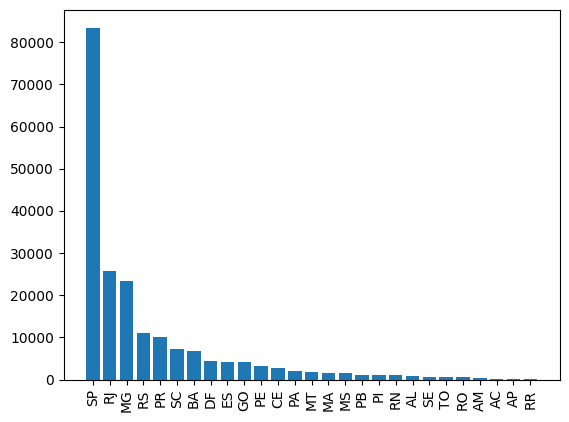

In [29]:
query = """ SELECT customer_state , COUNT(Customer_id)
FROM customers GROUP BY customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by ="customer_count", ascending=False)

plt.bar( df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018.

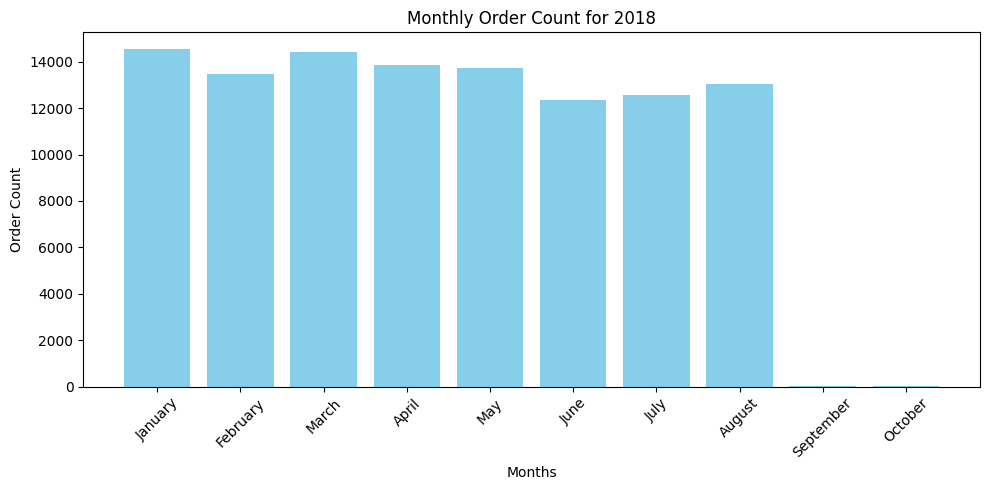

In [30]:
query = """
SELECT MONTHNAME(STR_TO_DATE(order_purchase_timestamp, '%m/%d/%Y %H:%i')) AS month_name,
       COUNT(order_id) AS order_count
FROM orders
WHERE YEAR(STR_TO_DATEA(order_purchase_timestamp, '%m/%d/%Y %H:%i')) = 2018
GROUP BY month_name
ORDER BY STR_TO_DATE(CONCAT('01 ', month_name, ' 2018'), '%d %M %Y');
"""
cur.execute(query)
data = cur.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

# Ensure correct month order
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
df["months"] = pd.Categorical(df["months"], categories=month_order, ordered=True)
df = df.sort_values("months")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df["months"], df["order_count"], color='skyblue')
plt.xticks(rotation=45)
plt.title("Monthly Order Count for 2018")
plt.xlabel("Months")
plt.ylabel("Order Count")
plt.tight_layout()
plt.show()
 


# Find the average number of products per order, grouped by customer city.

In [31]:
query = """WITH count_per_order AS (
    SELECT 
        o.order_id, 
        o.customer_id, 
        COUNT(oi.order_id) AS oc
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY o.order_id, o.customer_id
)

SELECT 
    c.customer_city, 
    ROUND(AVG(cpo.oc), 2) AS average_orders
FROM customers c
JOIN count_per_order cpo ON c.customer_id = cpo.customer_id
GROUP BY c.customer_city;

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer city", "average orders"])
df.head(10)



,Customer city,average orders
0,sao paulo,4.62
1,sao jose dos campos,4.55
2,porto alegre,4.70
3,indaial,4.46
4,treze tilias,5.09
5,rio de janeiro,4.59
6,mario campos,5.33
7,guariba,4.00
8,cuiaba,4.79
9,franca,5.01


# Calculate the percentage of total revenue contributed by each product category.

In [32]:
query = """SELECT 
    UPPER(products.product_category) AS category, 
    round((SUM(payments.payment_value) / 
     (SELECT SUM(payment_value) FROM payments)
    ) * 100,2) AS sales_percentage
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales_percentage desc;
"""
cur.execute(query)
data = cur.fetchall() 
df = pd.DataFrame(data, columns = ["Customer city", "average products/order"])
df.head(10)

,Customer city,average products/order
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
5,SPORT LEISURE,34.78
6,HOUSEWARES,27.35
7,AUTOMOTIVE,21.30
8,GARDEN TOOLS,20.95
9,COOL STUFF,19.48


# Identify the correlation between product price and the number of times a product has been purchased.

In [33]:
query = """
    SELECT 
        products.product_category,
        COUNT(order_items.product_id) AS product_count,
        ROUND(AVG(order_items.price), 2)    
    FROM products 
    JOIN order_items ON products.product_id = order_items.product_id
    GROUP BY products.product_category;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "product_count", "price"])

arr1 = df["product_count"]
arr2 = df["price"]

print(np.corrcoef([arr1, arr2]))


[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]


# Calculate the total revenue generated by each seller, and rank them by revenue.

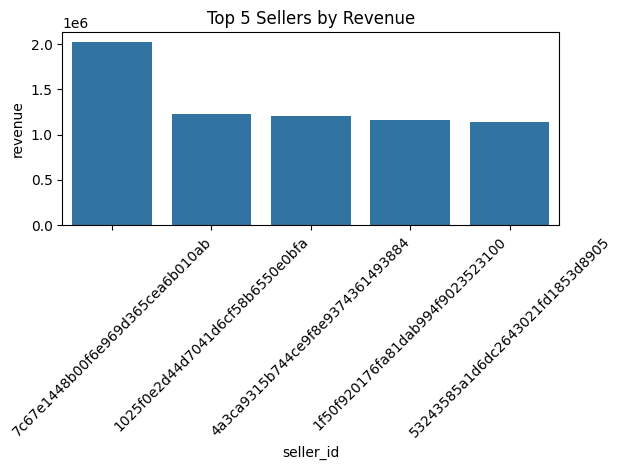

In [36]:
query = """
SELECT *, 
       DENSE_RANK() OVER (ORDER BY total_payment DESC) AS rn
FROM (
    SELECT order_items.seller_id, 
           SUM(payments.payment_value) AS total_payment
    FROM order_items 
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS a;
"""

cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["seller_id", "revenue", "ranks"])
df = df.head(5)

# Plot
sns.barplot(x="seller_id", y="revenue", data=df)
plt.xticks(rotation=45)
plt.title("Top 5 Sellers by Revenue")
plt.tight_layout()
plt.show()


 # Calculate the moving average of order values for each customer over their order history.

In [37]:
query = """SELECT customer_id, 
       order_purchase_timestamp,
       AVG(payment) OVER (
           PARTITION BY customer_id 
           ORDER BY order_purchase_timestamp 
           ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
       ) AS mov_avg
FROM (
    SELECT orders.customer_id, 
           orders.order_purchase_timestamp,
           payments.payment_value AS payment
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
) AS a;

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id", "History_time ", "Moving Average"])
df.head(10)

,customer_id,History_time,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,11/14/2017 16:08,114.739998
1,00012a2ce6f8dcda20d059ce98491703,11/14/2017 16:08,114.739998
2,00012a2ce6f8dcda20d059ce98491703,11/14/2017 16:08,114.739998
3,00012a2ce6f8dcda20d059ce98491703,11/14/2017 16:08,114.739998
4,000161a058600d5901f007fab4c27140,7/16/2017 9:40,67.410004
5,000161a058600d5901f007fab4c27140,7/16/2017 9:40,67.410004
6,000161a058600d5901f007fab4c27140,7/16/2017 9:40,67.410004
7,000161a058600d5901f007fab4c27140,7/16/2017 9:40,67.410004
8,0001fd6190edaaf884bcaf3d49edf079,2/28/2017 11:06,195.419998
9,0001fd6190edaaf884bcaf3d49edf079,2/28/2017 11:06,195.419998


# Calculate the cumulative sales per month for each year.

In [40]:
query = """SELECT 
    a.years, 
    a.months, 
    a.monthly_payment, 
    SUM(a.monthly_payment) OVER (PARTITION BY a.years ORDER BY a.months) AS cumulative_sales
FROM (
    SELECT 
        YEAR(STR_TO_DATE(o.order_purchase_timestamp, '%d/%m/%Y %H:%i')) AS years,
        MONTH(STR_TO_DATE(o.order_purchase_timestamp, '%d/%m/%Y %H:%i')) AS months,
        ROUND(SUM(p.payment_value), 2) AS monthly_payment
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    GROUP BY years, months
) AS a
ORDER BY a.years, a.months;

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Months", "monthly_payments","cumulative_sales"])
df.head(10)

,Year,Months,monthly_payments,cumulative_sales
0,NaN,NaN,38058776.19,38058776.19
1,2016.0,2.0,437.36,437.36
2,2016.0,3.0,2380.56,2817.92
3,2016.0,4.0,48203.52,51021.44
4,2016.0,5.0,41149.12,92170.56
5,2016.0,6.0,37594.44,129765.00
6,2016.0,7.0,33020.76,162785.76
7,2016.0,8.0,38864.52,201650.28
8,2016.0,9.0,16608.44,218258.72
9,2016.0,10.0,18700.40,236959.12


# Calculate the year-over-year growth rate of total sales.

In [50]:
query = """
WITH a AS (
    SELECT 
        YEAR(STR_TO_DATE(orders.order_purchase_timestamp, '%d/%m/%Y %H:%i')) AS year,
        ROUND(SUM(payments.payment_value), 2) AS total_payment
    FROM orders
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY year
)
SELECT  
    year,
    total_payment,
    LAG(total_payment, 1) OVER (ORDER BY year) AS previous_year_payment,
    ROUND((total_payment - LAG(total_payment, 1) OVER (ORDER BY year)) / 
          LAG(total_payment, 1) OVER (ORDER BY year), 2) AS growth_rate
FROM a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Total_Payment", "Previous_Year_Payment", "Growth_Rate"])
df.head(10)


,Year,Total_Payment,Previous_Year_Payment,Growth_Rate
0,NaN,38058776.19,NaN,NaN
1,2016.0,236959.12,38058776.19,-0.99
2,2017.0,11210684.96,236959.12,46.31
3,2018.0,14529068.21,11210684.96,0.30


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [52]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# dentify the top 3 customers who spent the most money in each year.

     year                                id       payment  rank
0     NaN  1617b1357756262bfa56ab541c47bc16  54656.320312     1
1     NaN  ec5b2ba62e574342386871631fafd3fc  29099.519531     2
2     NaN  f48d464a0baaea338cb25f816991ab1f  27688.839844     3
3  2016.0  a9dc96b027d1252bbac0a9b72d837fc6   5694.200195     1
4  2016.0  1d34ed25963d5aae4cf3d7f3a4cda173   5602.959961     2


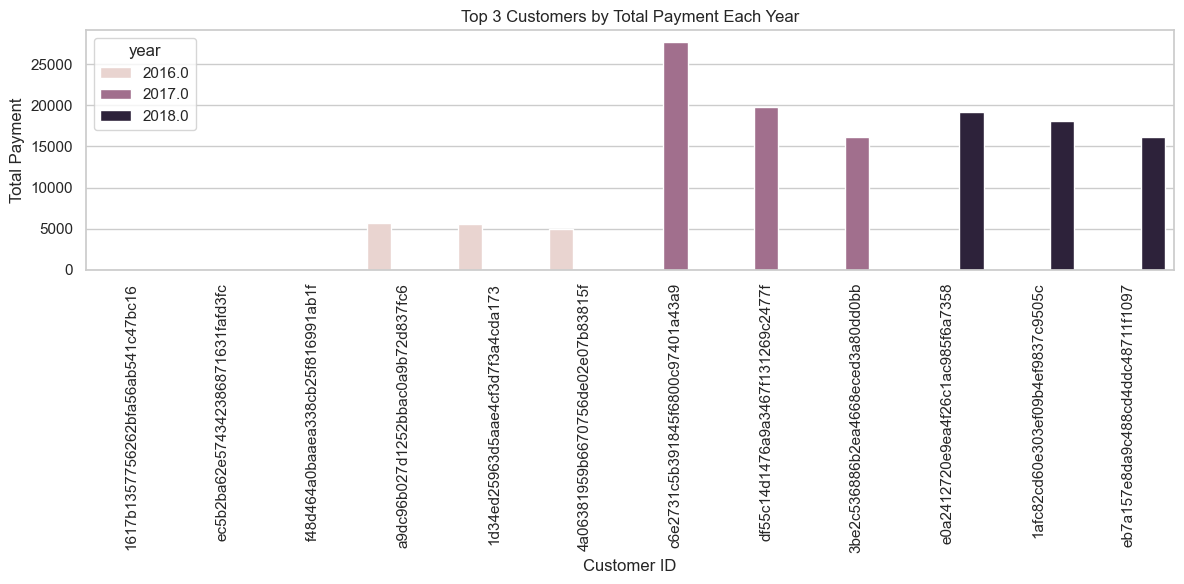

In [60]:

query = """
WITH customer_yearly_payments AS (
    SELECT 
        YEAR(STR_TO_DATE(orders.order_purchase_timestamp, '%d/%m/%Y %H:%i')) AS year,
        orders.customer_id,
        SUM(payments.payment_value) AS total_payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY year, orders.customer_id
),
ranked_customers AS (
    SELECT 
        year,
        customer_id,
        total_payment,
        DENSE_RANK() OVER (PARTITION BY year ORDER BY total_payment DESC) AS payment_rank
    FROM customer_yearly_payments
)
SELECT 
    year, customer_id, total_payment, payment_rank
FROM ranked_customers
WHERE payment_rank <= 3;
"""
data = cur.fetchall()
df = pd.DataFrame(data, columns=["year", "id", "payment", "rank"])
print(df.head())
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x="id", y="payment", hue="year", data=df)
plt.xticks(rotation=90)
plt.title("Top 3 Customers by Total Payment Each Year")
plt.ylabel("Total Payment")
plt.xlabel("Customer ID")
plt.tight_layout()
plt.show()
